In [12]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [59]:
# system
import sys
sys.path.append('..')

# data
import numpy as np

# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# torchvision
import torchvision

# plotting
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# utils and model
from utils.utils import (
    seedEverything,
    compute_mean_std,
    data_transform,
    normalize,
    plot_images,
)

from utils.model import ConvNN

# FIXMATCH
from fixmatch import mask, fixmatch_train

# os
import os
import path

# sklearn - confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [62]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.0005

In [64]:
# Download both datasets
trainset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=data_transform())
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=data_transform())

# convert to data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [65]:
# compute mean and std
if not os.path.exists('../data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, '../data/mean.pt')
    torch.save(std, '../data/std.pt')
else:
    mean, std = torch.load('../data/mean.pt'), torch.load('../data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")

mean: [0.49135667 0.48212072 0.4465159 ], std: [0.24632095 0.24274482 0.26062676]


In [66]:
# define classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [68]:
torch_models = './results/models/' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## III. Semi-Supervised Learning: Fixmatch

### III.1 Fixmatch on 10% train data

In [69]:
# fix the seed
seedEverything()

# 10% labeled data and 100% unlabeled (see note 2 in paper)
SUBSET_PROP = 0.10
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [80]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [81]:
fixmatch_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='10'
)

Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 22.89%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 26.16%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 35.2%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 41.93%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 43.41%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.84%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 48.04%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 45.13%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 52.11%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.54%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.23%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.83%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.35%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.23%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 52.63%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 56.22%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.9%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.76%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.17%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.29%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.42%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.07%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.06%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.99%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.06%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.81%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.39%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.38%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.19%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.86%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.66%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.89%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.79%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.93%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.28%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.4%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.16%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.08%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.05%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.96%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.08%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.85%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.24%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.73%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.74%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.65%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.41%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.64%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.49%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.95%


Epoch    50:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.9%


Epoch    51:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.21%


Epoch    52:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.79%


Epoch    53:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.88%


Epoch    54:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.6%


Epoch    55:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.36%


Epoch    56:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.31%


Epoch    57:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.1%


Epoch    58:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.98%


Epoch    59:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.78%


Epoch    60:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.13%


Epoch    61:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.3%


Epoch    62:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.07%


Epoch    63:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.8%


Epoch    64:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.85%


Epoch    65:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.8%


Epoch    66:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.22%


Epoch    67:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.7%


Epoch    68:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.9%


Epoch    69:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.93%


Epoch    70:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.8%


Epoch    71:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.34%


Epoch    72:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.85%


Epoch    73:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.66%


Epoch    74:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.5%


Epoch    75:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.71%


Epoch    76:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.13%


Epoch    77:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.33%


Epoch    78:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.05%


Epoch    79:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.71%


Epoch    80:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.23%


Epoch    81:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.8%


Epoch    82:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.49%


Epoch    83:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.95%


Epoch    84:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.83%


Epoch    85:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.54%


Epoch    86:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.87%


Epoch    87:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.41%


Epoch    88:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.62%


Epoch    89:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.34%


Epoch    90:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.93%


Epoch    91:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.11%


Epoch    92:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.54%


Epoch    93:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.79%


Epoch    94:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.65%


Epoch    95:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.8%


Epoch    96:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.86%


Epoch    97:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.08%


Epoch    98:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.17%


Epoch    99:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.35%


Epoch   100:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.26%


Epoch   101:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.73%


Epoch   102:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.83%


Epoch   103:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.87%


Epoch   104:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.93%


Epoch   105:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.85%


Epoch   106:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.86%


Epoch   107:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.33%


Epoch   108:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.49%


Epoch   109:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.56%


Epoch   110:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.3%


Epoch   111:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.31%


Epoch   112:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.76%


Epoch   113:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.51%


Epoch   114:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.05%


Epoch   115:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.94%


Epoch   116:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.26%


Epoch   117:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.09%


Epoch   118:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.23%


Epoch   119:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.3%


Epoch   120:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.72%


Epoch   121:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.0%


Epoch   122:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.56%


Epoch   123:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.82%


Epoch   124:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.09%


Epoch   125:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.83%


Epoch   126:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.67%


Epoch   127:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.1%


Epoch   128:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.8%


Epoch   129:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.62%


Epoch   130:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.91%


Epoch   131:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.79%


Epoch   132:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.46%


Epoch   133:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.51%


Epoch   134:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.62%


Epoch   135:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.5%


Epoch   136:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.8%


Epoch   137:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.63%


Epoch   138:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.2%


Epoch   139:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.87%


Epoch   140:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.75%


Epoch   141:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.63%


Epoch   142:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.52%


Epoch   143:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.11%


Epoch   144:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.26%


Epoch   145:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.8%


Epoch   146:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.6%


Epoch   147:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.19%


Epoch   148:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.44%


Epoch   149:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.53%


Epoch   150:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.06%


Epoch   151:   0%|          | 0/79 [00:00<?, ?batch/s]

In [ ]:
# open results
model_10 = torch.load('./results/models/model_10.pth')
train_losses_10 = torch.load('./results/metrics/train_losses_10.pth')
train_accuracies_10 = torch.load('./results/metrics/train_accuracies_10.pth')
test_losses_10 = torch.load('./results/metrics/test_losses_10.pth')
test_accuracies_10 = torch.load('./results/metrics/test_accuracies_10.pth')

In [ ]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_10, label="train")
ax1.plot(test_losses_10, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_10, label="train")
ax2.plot(test_accuracies_10, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"/results/figures/losses_accuracies_10.png")

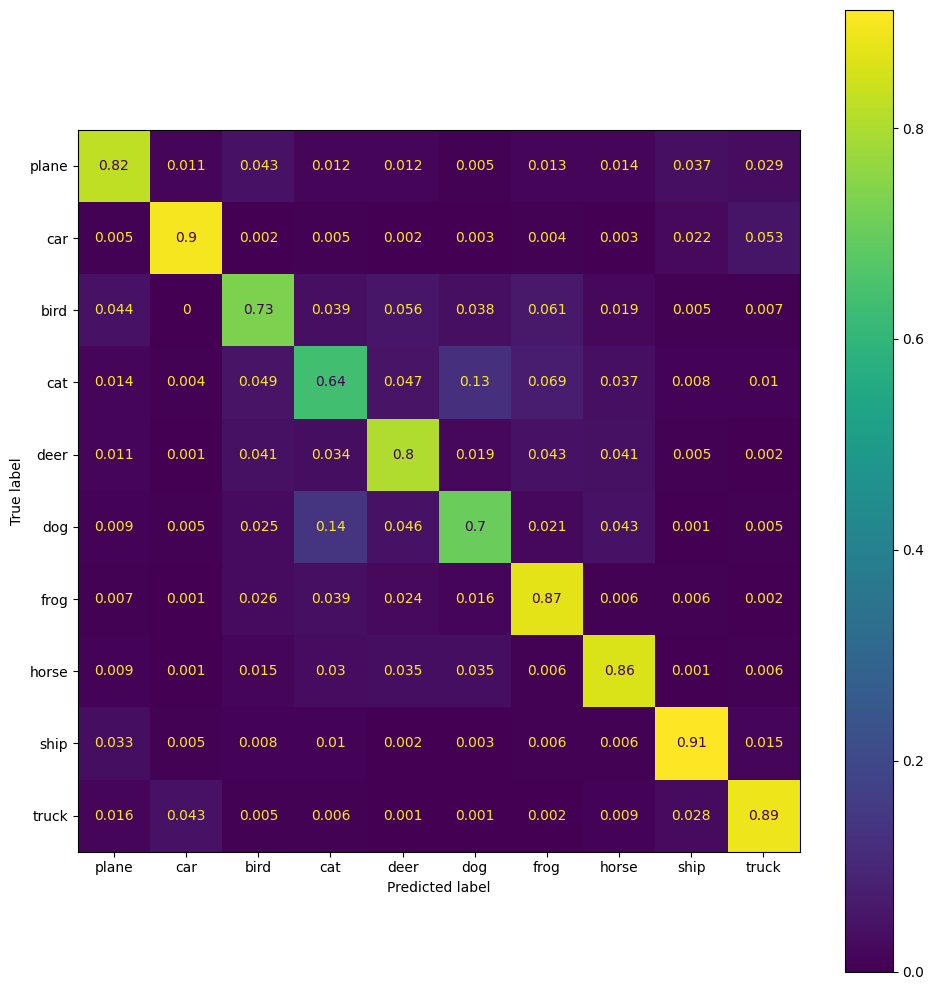

In [16]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_10(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/confusion_matrix_10.png")

Test Accuracy: 81.33%


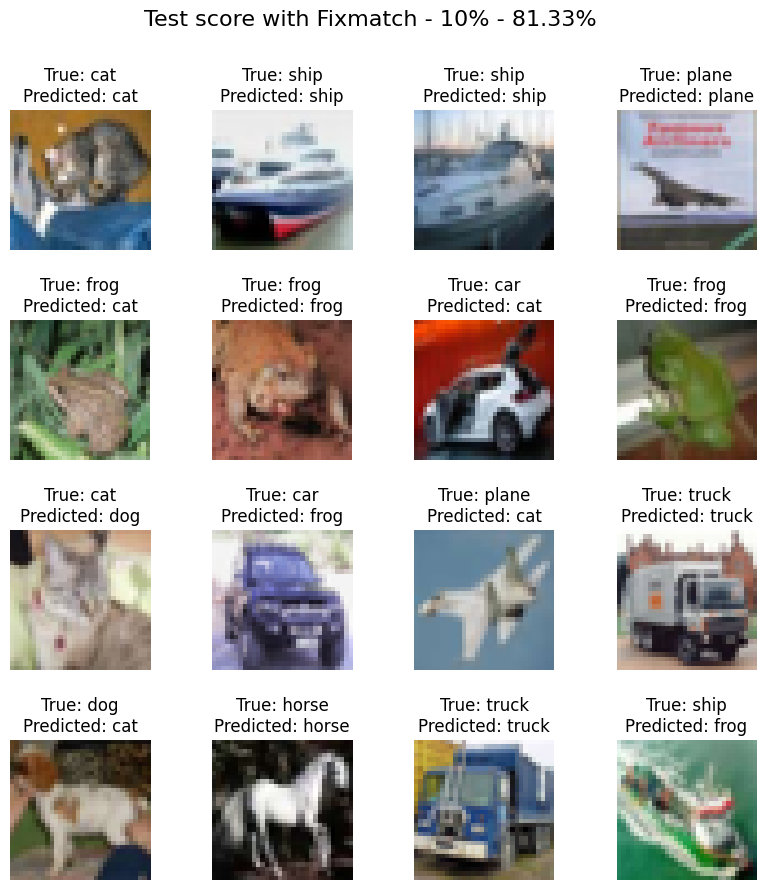

In [17]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image = normalize(mean, std)(test_image)
outputs_test = model_10(test_image)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_10.png")

### III.2 Fixmatch on 5% train data

In [ ]:
# fix the seed
seedEverything()

# 10% labeled data and 100% unlabeled (see note 2 in paper)
SUBSET_PROP = 0.05
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

In [ ]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [ ]:
fixmatch_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='05'
)

In [ ]:
# open results
model_05 = torch.load('./results/models/model_05.pth')
train_losses_05 = torch.load('./results/metrics/train_losses_05.pth')
train_accuracies_05 = torch.load('./results/metrics/train_accuracies_05.pth')
test_losses_05 = torch.load('./results/metrics/test_losses_05.pth')
test_accuracies_05 = torch.load('./results/metrics/test_accuracies_05.pth')

In [ ]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_05, label="train")
ax1.plot(test_losses_05, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_05, label="train")
ax2.plot(test_accuracies_05, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"/results/figures/losses_accuracies_05.png")

In [ ]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_05(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/confusion_matrix_05.png")

In [ ]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image = normalize(mean, std)(test_image)
outputs_test = model_05(test_image)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_05.png")

### III.3 Fixmatch on 1% train data

In [23]:
# fix the seed
seedEverything()

# 10% labeled data and 100% unlabeled (see note 2 in paper)
SUBSET_PROP = 0.01
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [ ]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [ ]:
fixmatch_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='01'
)

In [ ]:
# open results
model_01 = torch.load('./results/models/model_01.pth')
train_losses_01 = torch.load('./results/metrics/train_losses_01.pth')
train_accuracies_01 = torch.load('./results/metrics/train_accuracies_01.pth')
test_losses_01 = torch.load('./results/metrics/test_losses_01.pth')
test_accuracies_01 = torch.load('./results/metrics/test_accuracies_01.pth')

In [ ]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_01, label="train")
ax1.plot(test_losses_01, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_01, label="train")
ax2.plot(test_accuracies_01, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"/results/figures/losses_accuracies_01.png")

In [ ]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_01(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"figures/confusion_matrix_01.png")

In [ ]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image = normalize(mean, std)(test_image)
outputs_test = model_01(test_image)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./figures/test_score_01.png")